In [2]:
import os
import glob
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import pysal as ps
from pysal.contrib.viz import mapping as maps
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Applications/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [3]:
#load in walk boundaries from WalkScore
boundary_directory = "../01-Data/03-WalkScore_Boundaries/"
boundary_file_paths = glob.glob(boundary_directory+"*.json")

In [4]:
geo_objects = []
geo_paths = []
walk_time = []
for path in boundary_file_paths:
    with open(path, encoding='utf-8') as data_file:
        json_data = json.loads(data_file.read())
        geo_objects.append(json_data['coordinates'][0])
        walk_time.append(int(path.split("/")[3].split("_")[1]))
        geo_paths.append(path)

In [5]:
df = pd.DataFrame({'coordinates':geo_objects,'walk_time':walk_time,'file_path':geo_paths})
df.sort_values('walk_time', inplace=True)

In [6]:
df['boundary_length'] = [len(record) for record in df['coordinates']]

In [10]:
df = df[df['boundary_length']>10]
df.reset_index(drop=True, inplace=True)
df.head()

,coordinates,walk_time,file_path,boundary_length
0,"[[-71.05805198992574, 42.349989459211564], [-7...",1,../01-Data/03-WalkScore_Boundaries/walk_1_minu...,216
1,"[[-71.05814882710878, 42.350469828903435], [-7...",2,../01-Data/03-WalkScore_Boundaries/walk_2_minu...,400
2,"[[-71.05757273840976, 42.351140034496694], [-7...",3,../01-Data/03-WalkScore_Boundaries/walk_3_minu...,583
3,"[[-71.05735041039854, 42.35191116378106], [-71...",4,../01-Data/03-WalkScore_Boundaries/walk_4_minu...,781
4,"[[-71.0570702695607, 42.35337027665249], [-71....",6,../01-Data/03-WalkScore_Boundaries/walk_6_minu...,987


In [13]:
X = list()
Y = list()
time = list()
for i in range(len(df)):
    for j in range(len(df.iloc[i]['coordinates'])):
        X.append(df.iloc[i]['coordinates'][j][0])
        Y.append(df.iloc[i]['coordinates'][j][1])
        time.append(df.iloc[i]['walk_time'])
    

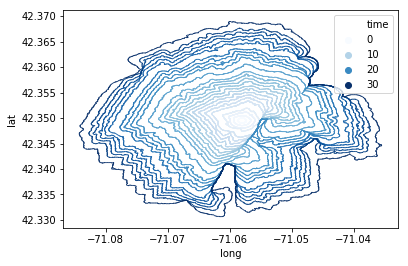

In [26]:
df_coords = pd.DataFrame({'long':X,'lat':Y,'time':time})
sns.scatterplot(x='long',y='lat',data=df_coords, hue='time',palette='Blues', linewidth=0,s=1)

## build dataset

In [29]:
long_min = min(X)-.01
long_max = max(X)+.01
lat_min = min(Y)-.01
lat_max = max(Y)+.01

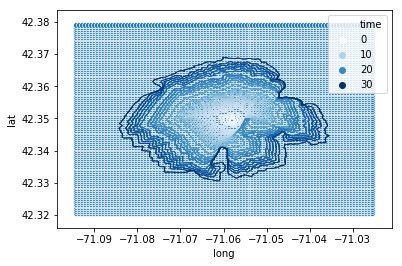

In [135]:
grid_step = 100

xg = np.linspace(long_min,long_max,grid_step)
yg = np.linspace(lat_min,lat_max,grid_step)
xv,yv = np.meshgrid(xg,yg)

xg = list(xv.reshape(1,-1)[0])
yg = list(yv.reshape(1,-1)[0])

sns.scatterplot(xg,yg)
sns.scatterplot(x='long',y='lat',data=df_coords, hue='time',palette='Blues', linewidth=0,s=1)

In [148]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

origin_loc = Point(42.349209, -71.058680)
bridge_loc = Point(42.351398, -71.052803)

point_x = []
point_y = []
origin = []
d_origin = []
bridge = []
d_bridge = []
time = []
in_boundary = []



for i in range(len(boundary_file_paths)):
    with open(boundary_file_paths[i], encoding='utf-8') as data_file:
        json_data = json.loads(data_file.read())
        polygon = Polygon(json_data['coordinates'][0])
        time_period = int(boundary_file_paths[i].split("/")[3].split("_")[1])
        
        for i in range(len(xg)):
            point_loc = Point(xg[i],yg[i])
            o_distance = origin_loc.distance(point_loc)
            b_distance = bridge_loc.distance(point_loc)
            in_boundary_check = polygon.contains(point_loc)
            
            point_x.append(point_loc.x)
            point_y.append(point_loc.y)
            origin.append((origin_loc.x,origin_loc.y))
            d_origin.append(o_distance)
            bridge.append((bridge_loc.x,bridge_loc.y))
            d_bridge.append(b_distance)
            time.append(time_period)
            in_boundary.append(in_boundary_check)
    
df_grid = pd.DataFrame({'point_x':point_x,'point_y':point_y,'origin_loc':origin,'distance_to_origin':d_origin,
                        'bridge_loc':bridge,'distance_to_bridge':d_bridge,
                        'time_period':time,'in_boundary':in_boundary})

print(len(df_grid),"analyzed points")
df_grid.head()

290000 analyzed points


,point_x,point_y,origin_loc,distance_to_origin,bridge_loc,distance_to_bridge,time_period,in_boundary
0,-71.094225,42.320657,"(42.349209, -71.05868)",160.387926,"(42.351398, -71.052803)",160.385320,10,False
1,-71.093531,42.320657,"(42.349209, -71.05868)",160.387435,"(42.351398, -71.052803)",160.384829,10,False
2,-71.092837,42.320657,"(42.349209, -71.05868)",160.386944,"(42.351398, -71.052803)",160.384338,10,False
3,-71.092143,42.320657,"(42.349209, -71.05868)",160.386453,"(42.351398, -71.052803)",160.383847,10,False
4,-71.091449,42.320657,"(42.349209, -71.05868)",160.385962,"(42.351398, -71.052803)",160.383356,10,False


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


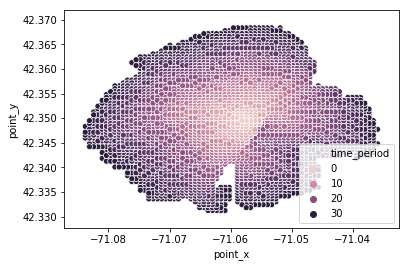

In [151]:
plot_data = df_grid[df_grid['in_boundary']==True]
plot_data.sort_values('time_period', inplace=True,ascending=False)
sns.scatterplot(x='point_x',y='point_y',data=plot_data, hue='time_period')